In [ ]:
# Colab setup

# Setup NASLib
#%cd /content
#!git clone -b zerocost https://github.com/automl/NASLib/
#!pip install gdown

In [1]:
# Download zc score files
#%cd NASLib
#!source scripts/bash_scripts/download_nbs_zero.sh all
#%cd ..

In [6]:
import importlib

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [17]:
import pandas as pd


#TODO 90 %
def plot_filtered(dfs, filter_zc, rank_zc, key='tau', quantile=0.9, zscore=3.5, **kwargs):
  dfs_filter = filter_by_zc_task(dfs, filter_zc, quantile, **kwargs)
  dfs_filtered = eval_zc(dfs, rank_zc, filter_index=dfs_filter)

  qtitle = int(quantile * 100) if isinstance(quantile, float) else [int(q) for q in quantile]
  title = f"Nets over {qtitle}% quantile in {filter_zc}, {rank_zc} by validation accuracy."
  legend = [f'lower 90% nets by accuracy', f'top 10% nets by accuracy', 'best 3 networks']
  plot_networks_zc(dfs_filtered, rank_zc, title, subplots_adjust=0.9, legend=legend, legend_loc='lower right', key=key, zscore=zscore)
  plt.show()

  ranks = {t: {k: v for k, v in d['all'].items() if 'ranking' in k} for t, d in dfs_filtered.items()}
  stats = pd.DataFrame({t: {k: v for k, v in d['all'].items() if k != 'index' and 'ranking' not in k} for t, d in dfs_filtered.items()})
  return stats, ranks, dfs_filtered

In [1]:
import os

from zc_combine.utils.naslib_utils import parse_scores, load_search_space
from zc_combine.ensemble.filter import common_n_largest, filter_by_zc_task
from zc_combine.utils.plot_utils import plot_common_networks, plot_accuracy_histogram, plot_top_quantile_zc, plot_networks_zc
from zc_combine.ensemble.eval import eval_zc

naslib_path = '../zero_cost/NASLib'

[f for f in os.listdir(os.path.join(naslib_path, 'naslib/data/')) if '.json' in f]

['zc_transbench101_macro.json',
 'zc_transbench101_micro.json',
 'zc_nasbench301.json',
 'zc_nasbench201.json',
 'zc_nasbench101.json']

# Transbench101 macro

In [105]:
#what = 'zc_transbench101_micro'
what = 'zc_nasbench301'

zc_transbench101_macro = load_search_space(naslib_path, what)

In [106]:
dfs = parse_scores(zc_transbench101_macro)

Some tasks share only few best networks or none!

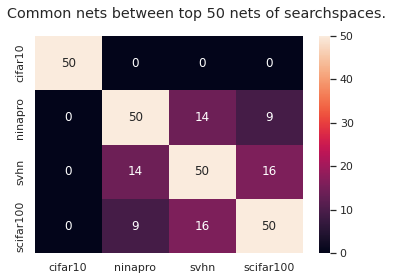

In [107]:
n_largest = 50
inds, common_nets = common_n_largest(dfs, n_largest=n_largest)

plot_common_networks(common_nets, inds, n_largest=n_largest)
plt.show()

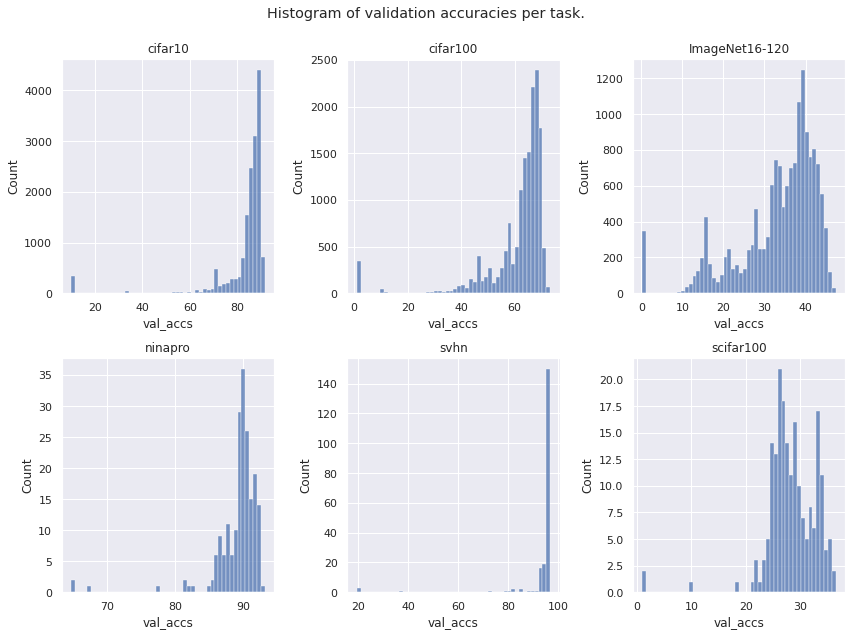

In [6]:
plot_accuracy_histogram(dfs)
plt.show()

/home/gabi/.env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gabi/.env/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/gabi/.env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gabi/.env/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/gabi/.env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gabi/.env/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/

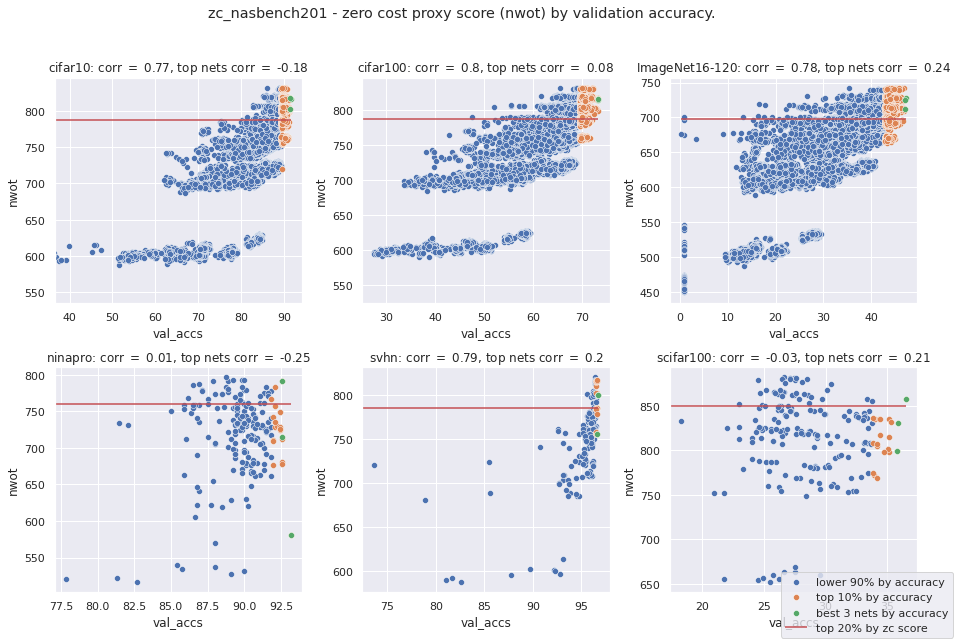

In [65]:
zc = 'nwot'

top_k = 3
acc_quantile = 0.9
zc_quantile = 0.8
dfs_stats = eval_zc(dfs, zc, top_k=top_k, acc_quantile=acc_quantile)

q = int(100 - acc_quantile * 100)
low_q = int(acc_quantile * 100)
zc_q = int(100 - zc_quantile * 100)

title = f"{what} - zero cost proxy score ({zc}) by validation accuracy."
legend = [f'lower {low_q}% by accuracy', f'top {q}% by accuracy', f'best {top_k} nets by accuracy', f'top {zc_q}% by zc score']
plot_networks_zc(dfs_stats, zc, title, top_line=True, subplots_adjust=0.87, legend=legend, legend_loc='lower right', zc_quantile=zc_quantile, key='corr',
                 figsize=(13, 9))
plt.show()

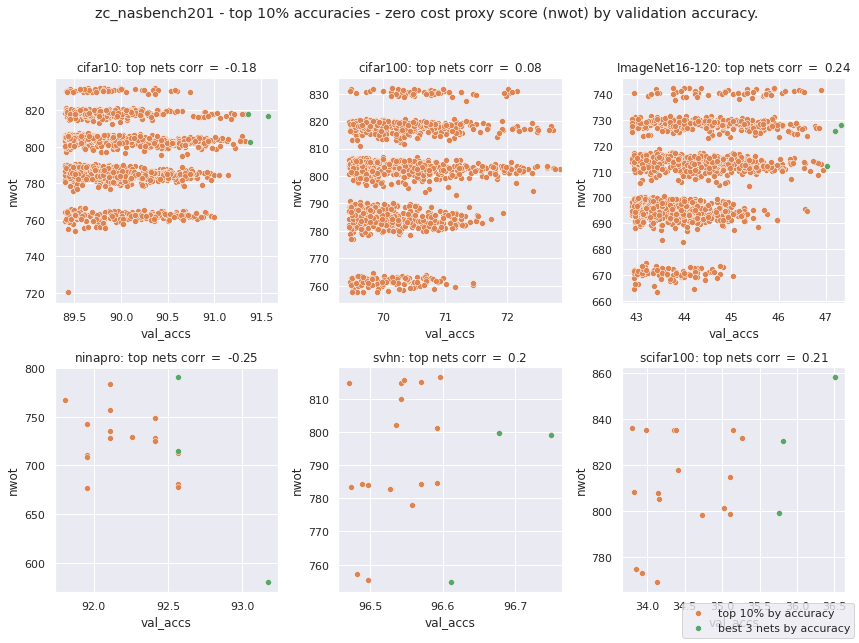

In [8]:
title = f"{what} - top {q}% accuracies - zero cost proxy score ({zc}) by validation accuracy."
legend = [f'top {q}% by accuracy', f'best {top_k} nets by accuracy']
plot_top_quantile_zc(dfs_stats, zc, title, subplots_adjust=0.87, legend=legend, legend_loc='lower right', zc_quantile=zc_quantile, key='corr')
plt.show()


# Combine two proxies

## Combine fisher and nwot

- fisher does not rank well top 10 % networks

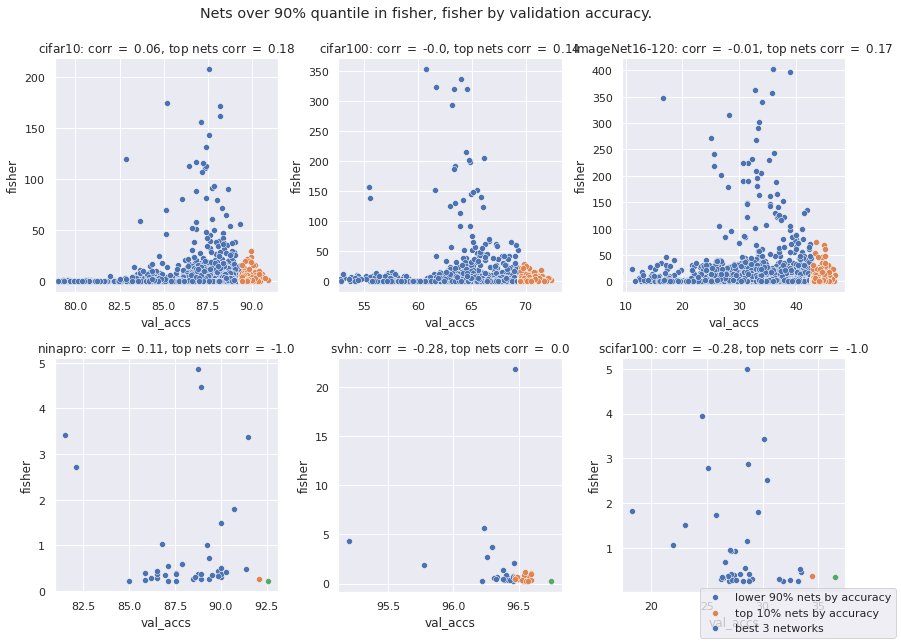

,cifar10,cifar100,ImageNet16-120,ninapro,svhn,scifar100
tau,0.050000,0.010000,-0.000000,0.080000,-0.200000,-0.190000
corr,0.060000,-0.000000,-0.010000,0.110000,-0.280000,-0.280000
acc_median,88.720000,68.520000,41.100000,88.770865,96.458205,28.119999
rank_median,11925.500000,12695.000000,12544.500000,50.500000,174.500000,100.000000
acc_median_drop,86.285000,64.270000,35.366667,90.136570,95.870467,28.169999
rank_median_drop,6762.000000,6811.500000,7171.500000,115.000000,83.000000,100.000000
acc_min,72.030000,42.840000,0.266667,81.487101,93.976644,18.319999
rank_min,1303.500000,805.000000,1.000000,6.000000,34.000000,4.000000
acc_min_drop,10.000000,1.000000,0.833333,64.795143,19.560541,1.000000
rank_min_drop,171.000000,1.500000,2.500000,1.500000,1.000000,1.000000


In [24]:
plot_filtered(dfs, 'fisher', 'fisher', quantile=0.8, key='corr')

- nwot is slightly better

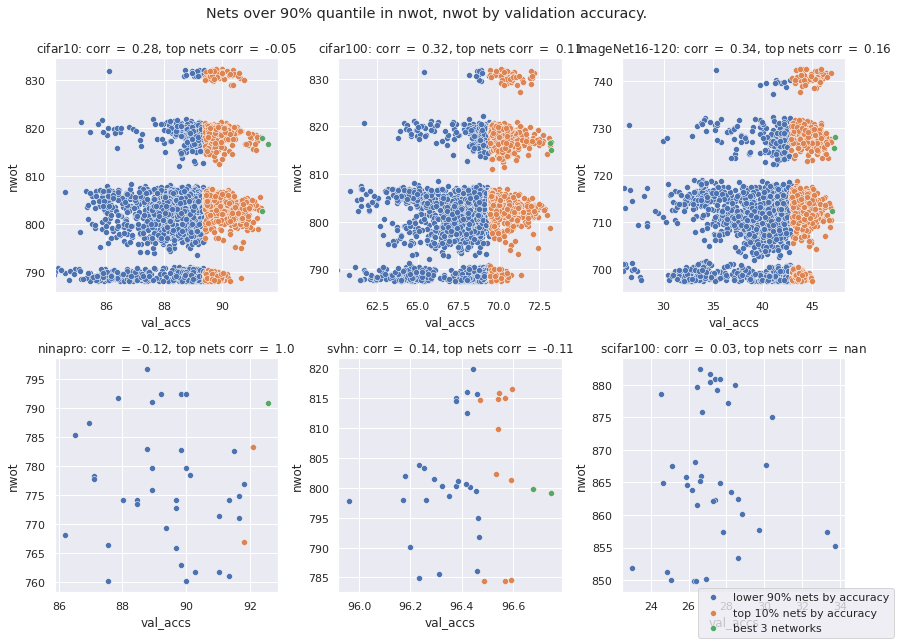

In [11]:
plot_filtered(dfs, 'nwot', 'nwot', quantile=0.8, key='corr')

- select top 10 % networks using fisher
- rank them using nwot
- performance is much better
   - compare with the fisher-fisher case above

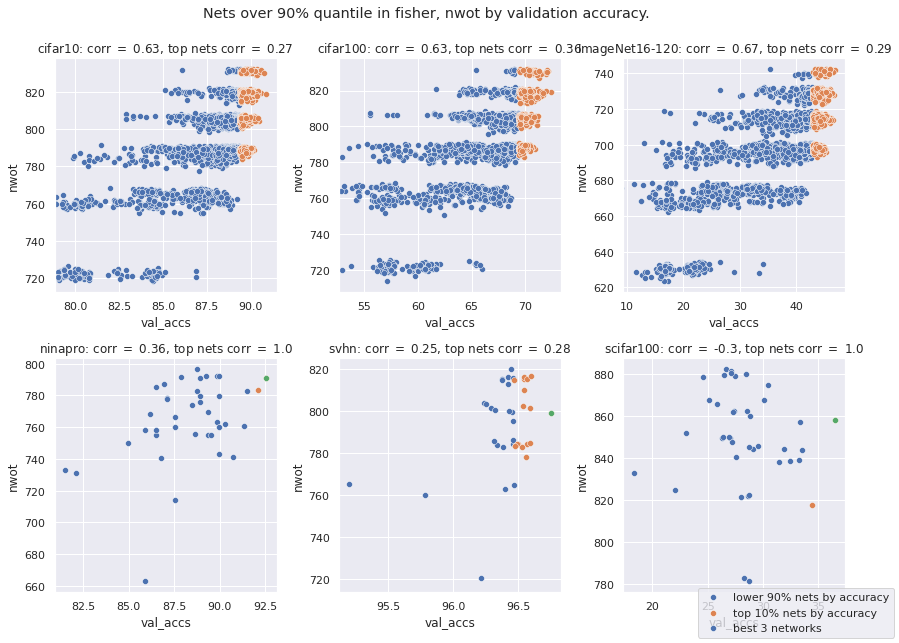

In [12]:
plot_filtered(dfs, 'fisher', 'nwot', quantile=0.8, key='corr')

- reversing the proxies leads to worse results

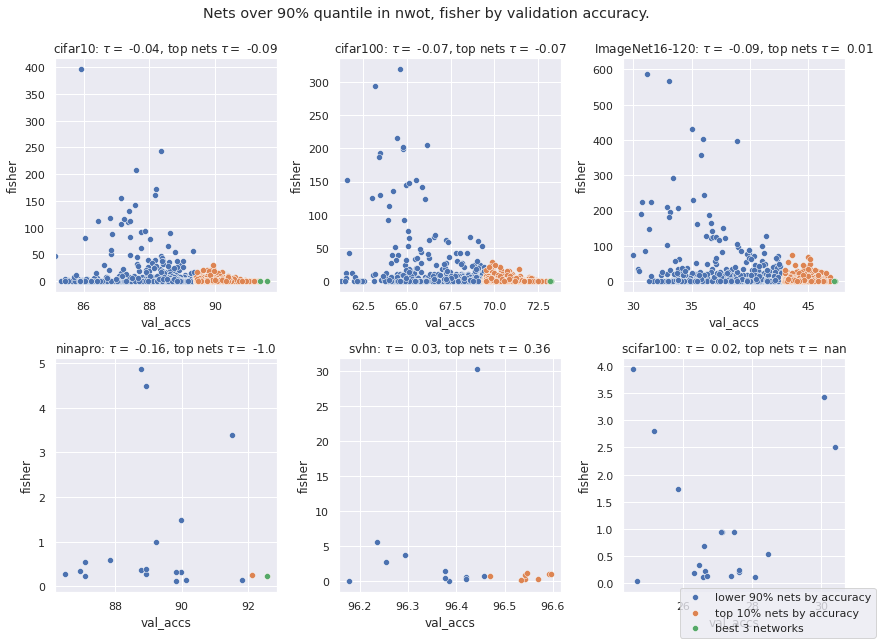

In [13]:
plot_filtered(dfs, 'nwot', 'fisher', quantile=0.9)

## Filter using multiple proxies

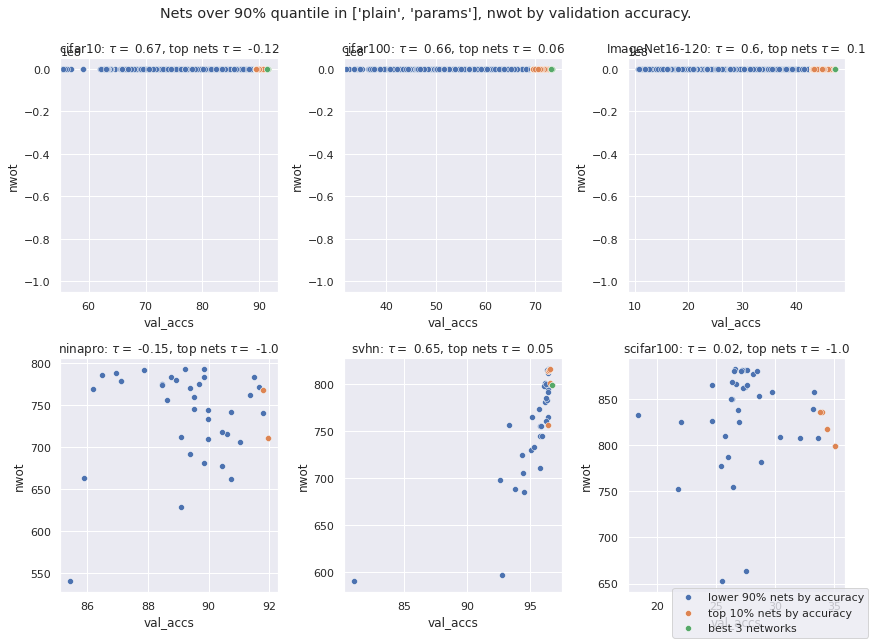

In [14]:
plot_filtered(dfs, ['plain', 'params'], 'nwot', mode='u')

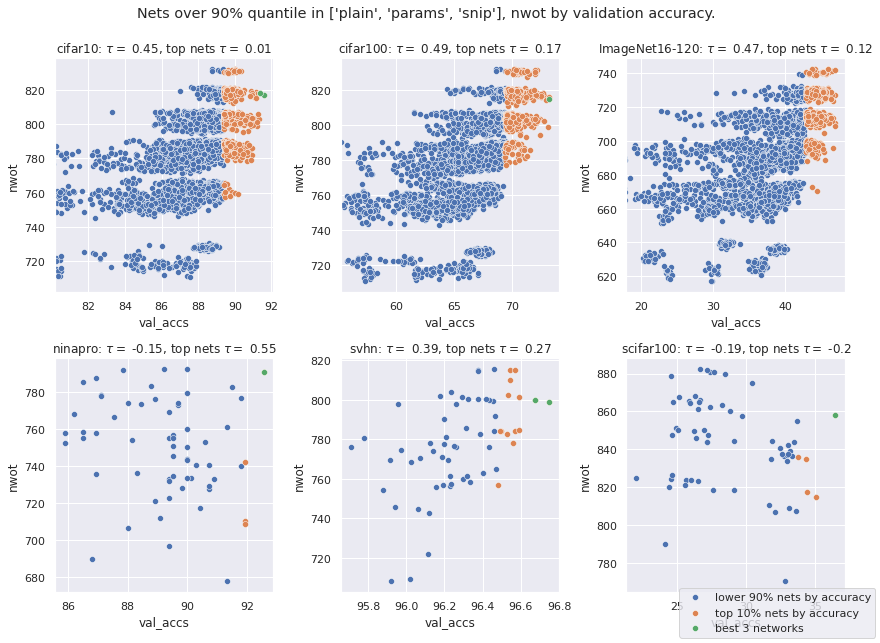

In [15]:
plot_filtered(dfs, ['plain', 'params', 'snip'], 'nwot', mode='s', quantile=[0.3, 0.3, 0.3])

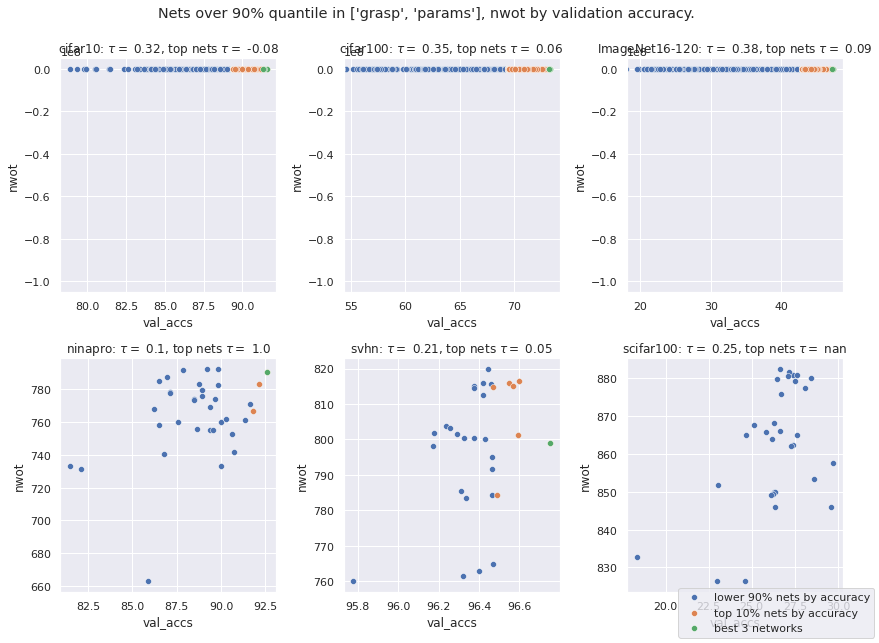

In [16]:
plot_filtered(dfs, ['grasp', 'params'], 'nwot', mode='u')

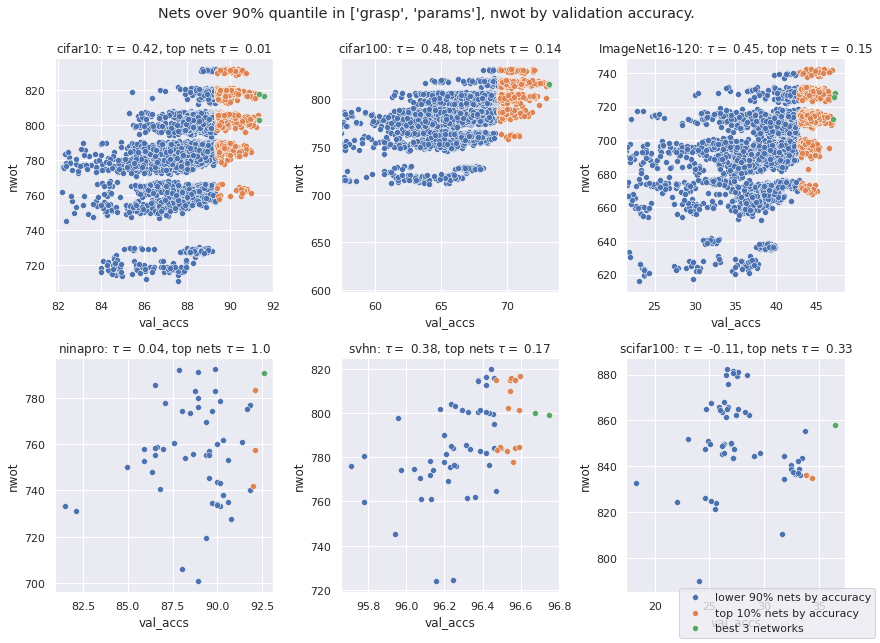

In [17]:
plot_filtered(dfs, ['grasp', 'params'], 'nwot', mode='i', quantile=0.5)

In [108]:
from zc_combine.ensemble.eval import eval_combined_proxies

some_key = next(iter(dfs.keys()))
proxies = [c for c in dfs[some_key].columns if c not in ['net', 'val_accs']]
inds, tau_scores = eval_combined_proxies(dfs, proxies, key='corr', zc_quantile=0.5)

In [109]:
tau_scores.keys()

dict_keys(['cifar10', 'ninapro', 'svhn', 'scifar100'])

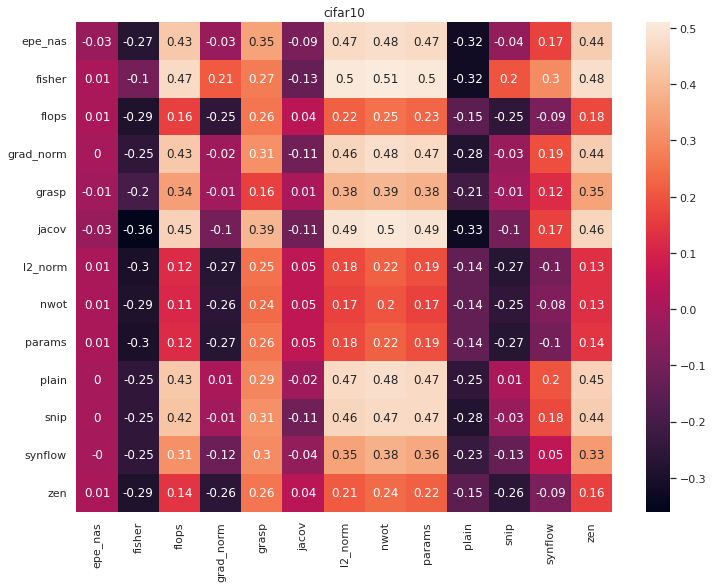

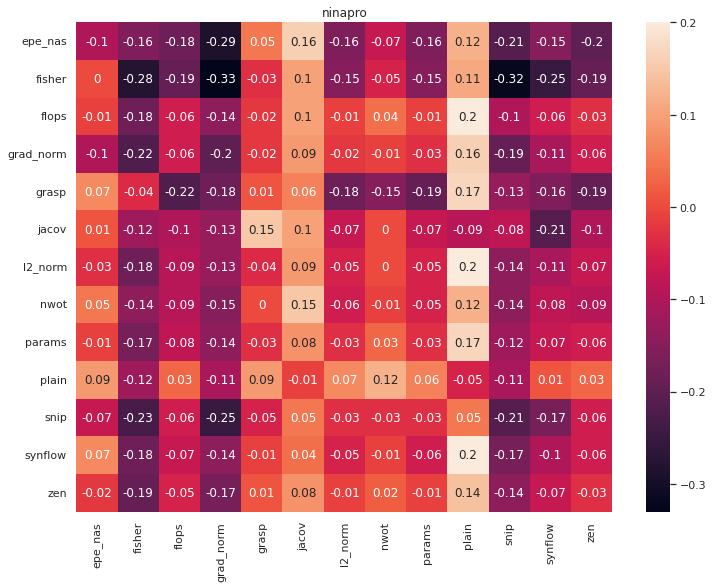

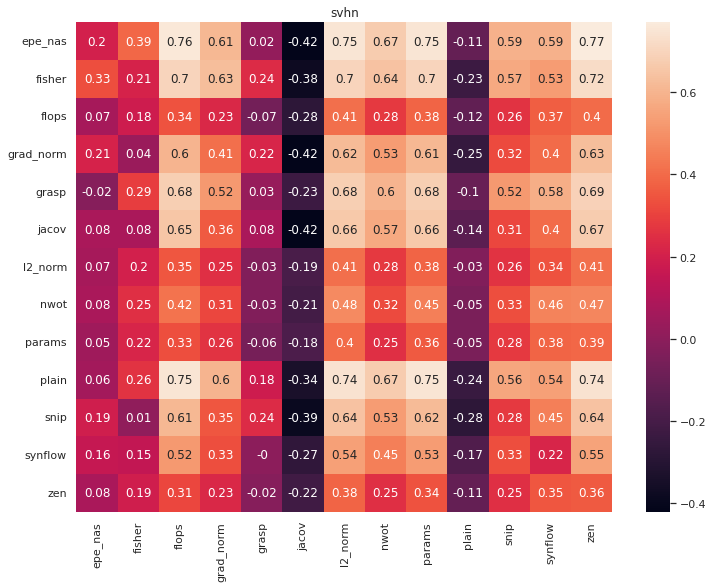

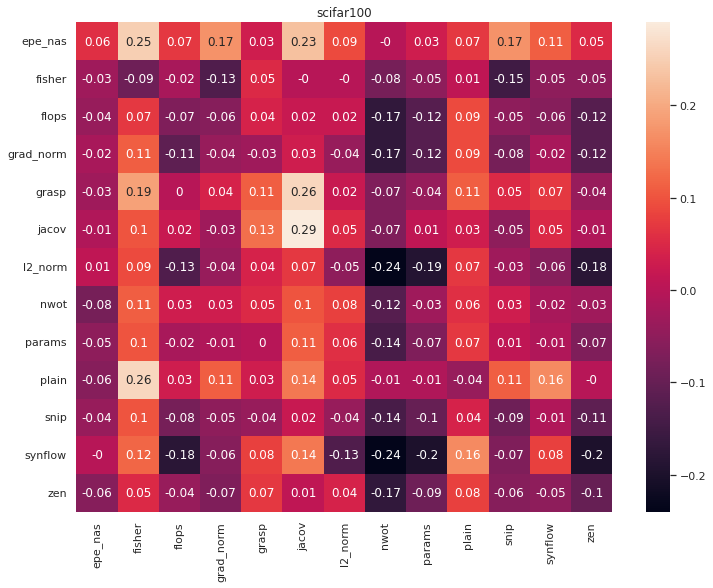

In [110]:
names = [inds[i] for i in range(len(inds))]

for k, v in tau_scores.items():
  plt.figure(figsize=(12,9))
  plt.title(k)
  sns.heatmap(tau_scores[k], annot=True, xticklabels=names, yticklabels=names)
  plt.show()

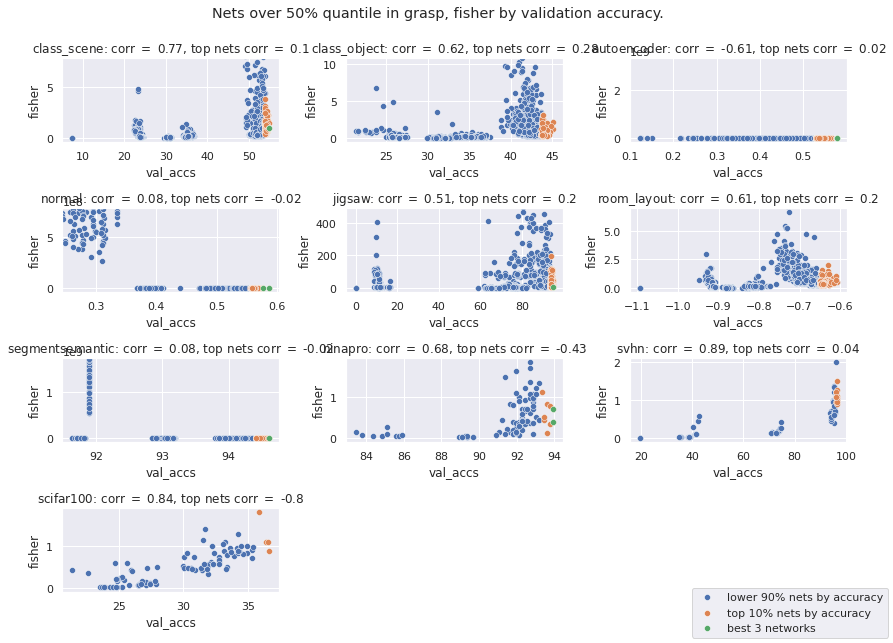

In [104]:
stats, ranks, dfilt = plot_filtered(dfs, 'grasp', 'fisher', quantile=0.5, key='corr', mode='s')

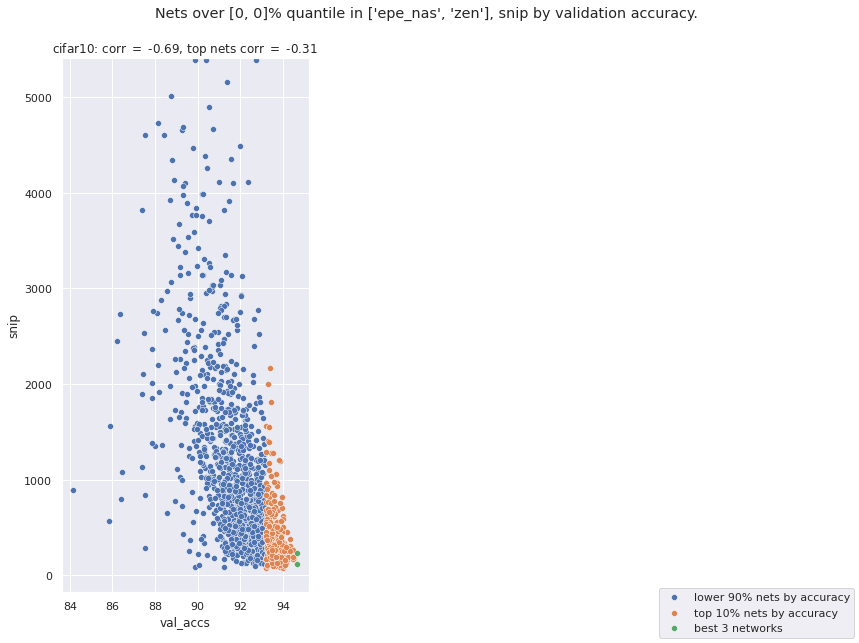

In [94]:
stats, ranks, dfilt = plot_filtered(dfs, ['epe_nas', 'zen'], 'snip', quantile=[0.5, 0.7], key='corr', mode='s')

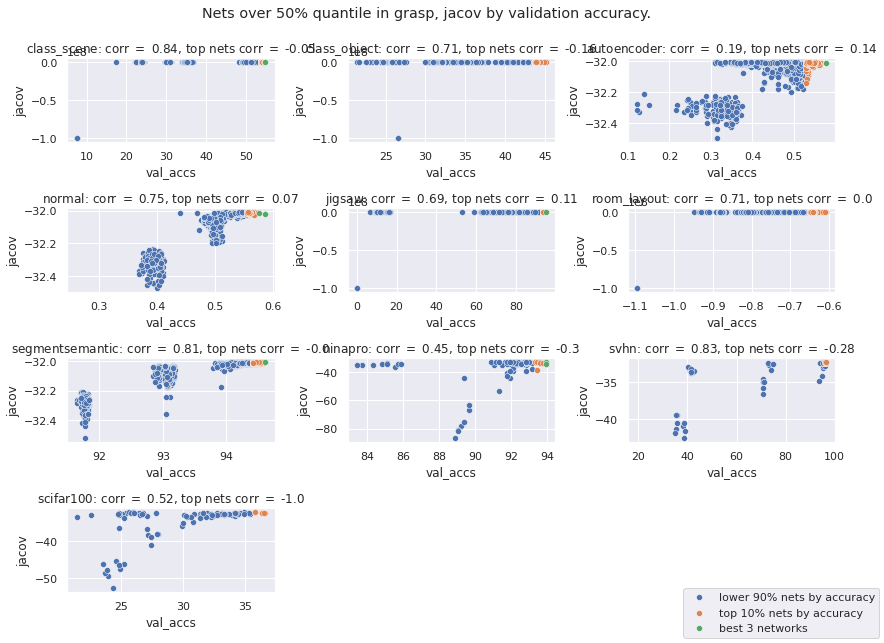

,class_scene,class_object,autoencoder,normal,jigsaw,room_layout,segmentsemantic,ninapro,svhn,scifar100
rank_median,2524.50000,2510.500000,2272.500000,2028.500000,2281.500000,2649.000000,2076.000000,111.000000,121.000000,105.500000
rank_median_drop,1539.00000,1713.750000,1788.500000,2058.250000,1872.000000,1869.500000,2018.750000,80.000000,73.750000,81.000000
rank_min,2.50000,7.000000,1.500000,1.000000,3.500000,4.000000,1.000000,2.000000,4.000000,4.000000
rank_min_drop,1.00000,1.000000,3.000000,3.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000
rank_mean,2442.87793,2362.598145,2180.811768,2053.690674,2236.661133,2323.631348,2043.386475,106.921875,110.104167,108.421875
rank_mean_drop,1654.12207,1734.401855,1916.188232,2043.309326,1860.338867,1773.368652,2053.613525,86.078125,82.895833,84.578125


In [25]:
#stats, ranks, dfilt = plot_filtered(dfs, 'zen', 'nwot', quantile=0.8, key='corr')
stats, ranks, dfilt = plot_filtered(dfs, 'grasp', 'jacov', quantile=0.5, key='corr', zscore=3.5)
stats.loc[['rank_median', 'rank_median_drop', 'rank_min', 'rank_min_drop', 'rank_mean', 'rank_mean_drop']]

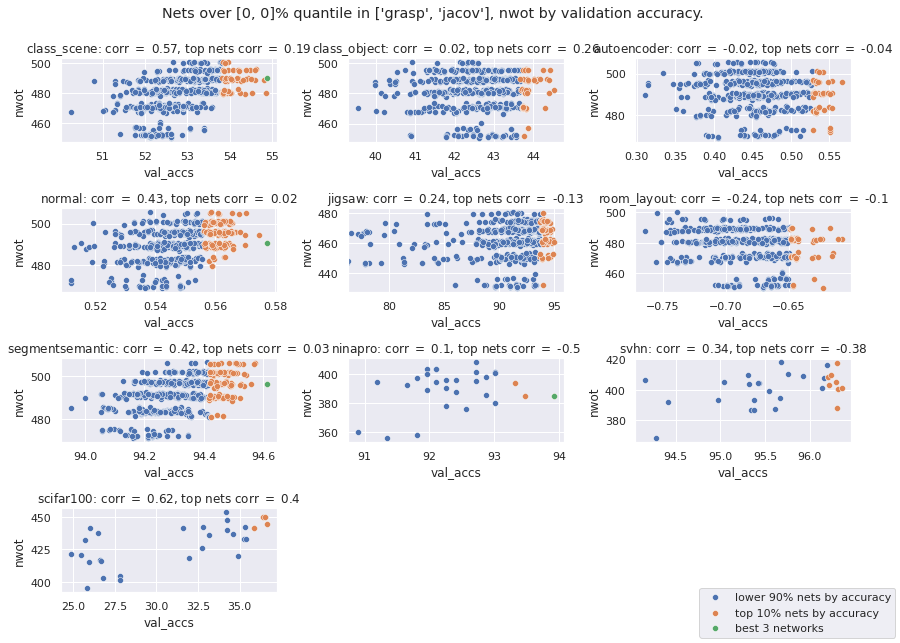

In [30]:
stats, ranks, dfilt = plot_filtered(dfs, ['grasp', 'jacov'], 'nwot', quantile=[0.5, 0.7], key='corr', zscore=3.5, mode='s')

/home/gabi/.env/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4921: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/gabi/.env/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4921: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/gabi/.env/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4921: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/gabi/.env/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4921: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/gabi/.env/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4921: ConstantInputWarning: An input ar

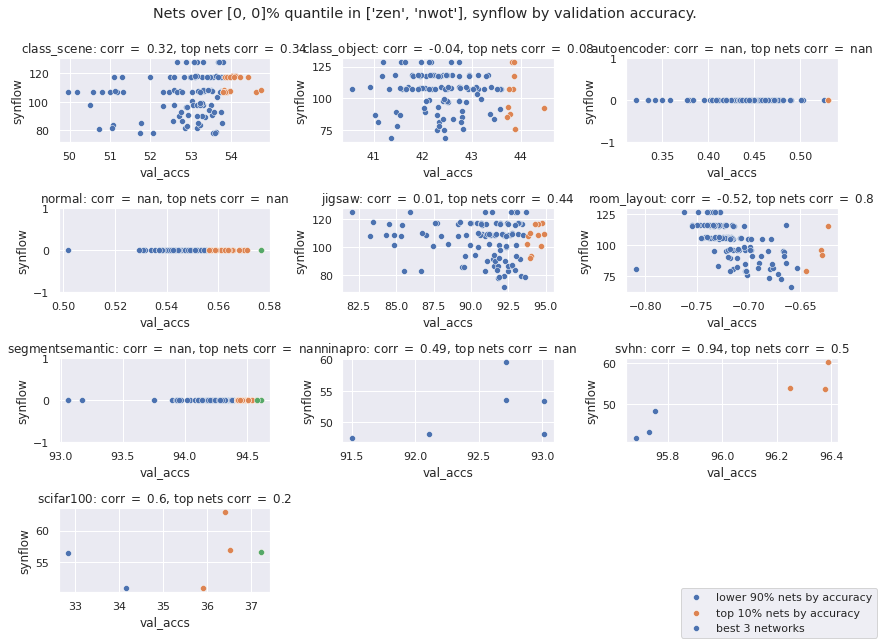

In [11]:
stats, ranks, dfilt = plot_filtered(dfs, ['zen', 'nwot'], 'synflow', quantile=[0.7, 0.9], key='corr', mode='s')

In [ ]:
stats, ranks, dfilt = plot_filtered(dfs, ['fisher', 'nwot'], 'l2_norm', quantile=[0.5, 0.5], key='corr', mode='s')
stats.loc[['rank_median', 'rank_median_drop', 'rank_min', 'rank_min_drop', 'rank_mean', 'rank_mean_drop']]

In [ ]:
#stats, ranks, dfilt = plot_filtered(dfs, 'zen', 'nwot', quantile=0.8, key='corr')
stats, ranks, dfilt = plot_filtered(dfs, 'fisher', 'nwot', quantile=0.5, key='corr')
stats.loc[['rank_median', 'rank_median_drop', 'rank_min', 'rank_min_drop', 'rank_mean', 'rank_mean_drop']]

In [ ]:
ranks['svhn'].keys()

In [ ]:
r = ranks['svhn']

r['ranking_filter']['name'] = 'filter'
r['ranking_drop']['name'] = 'drop'
rdata = pd.concat([r['ranking_filter'], r['ranking_drop']])

sns.histplot(data=rdata, x='rank', hue='name')
plt.show()

sns.histplot(data=rdata, x='val_accs', hue='name')
plt.show()

In [ ]:
r['ranking_filter'].sort_values('rank')

In [15]:
r['ranking_drop'].sort_values('rank')

,val_accs,rank,name
65,97.495387,2.0,drop
117,97.491546,3.0,drop
27,97.464656,4.0,drop
96,97.453132,5.0,drop
193,97.437766,7.0,drop
...,...,...,...
187,97.007527,184.0,drop
59,96.980637,188.0,drop
50,96.957588,190.0,drop
137,96.949905,191.0,drop


In [71]:
dfs['cifar10'].loc[6456]

net          (2, 3, 0, 2, 3, 2)
val_accs                  91.57
epe_nas             1756.764142
fisher                 0.018427
flops                124.126912
grad_norm             14.528912
grasp                  2.920427
jacov                -65.389701
l2_norm              282.939789
nwot                  816.72102
params                 0.858426
plain                  0.096632
snip                  30.142624
synflow              112.638228
zen                  159.187744
Name: 6456, dtype: object

In [21]:
dfilt['cifar10']['top_k']

{'k': 3, 'index': Int64Index([6456, 13588, 14151], dtype='int64')}

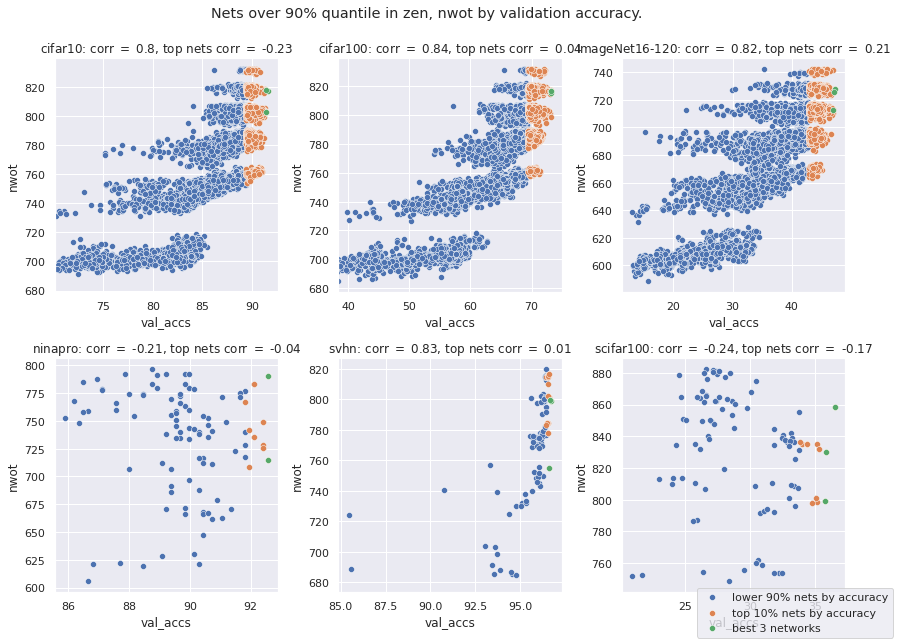

In [12]:
plot_filtered(dfs, 'zen', 'nwot', quantile=0.5, key='corr')  # TODO do correlation instead of tau

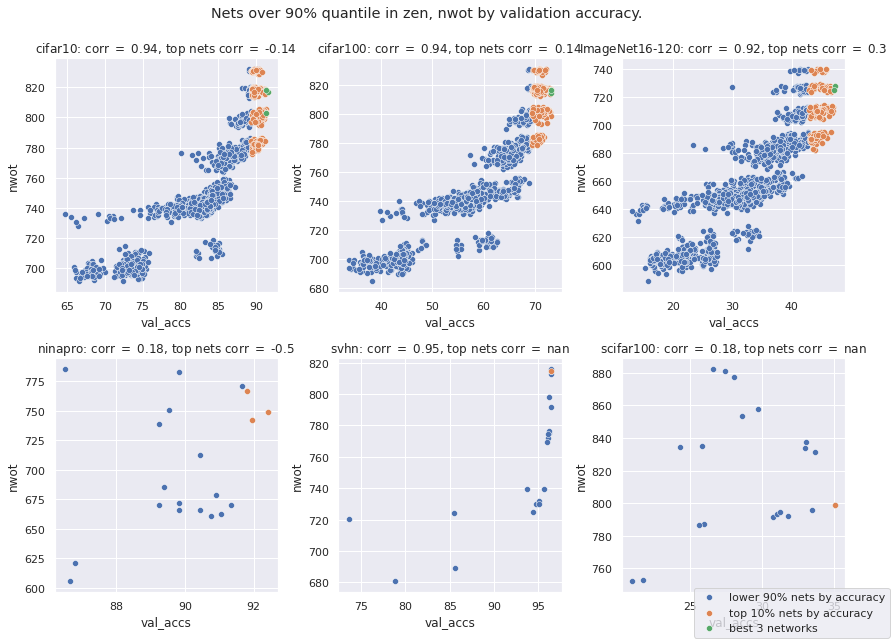

In [18]:
plot_filtered(dfs, 'zen', 'nwot', quantile=0.9, key='corr')  # TODO do correlation instead of tau

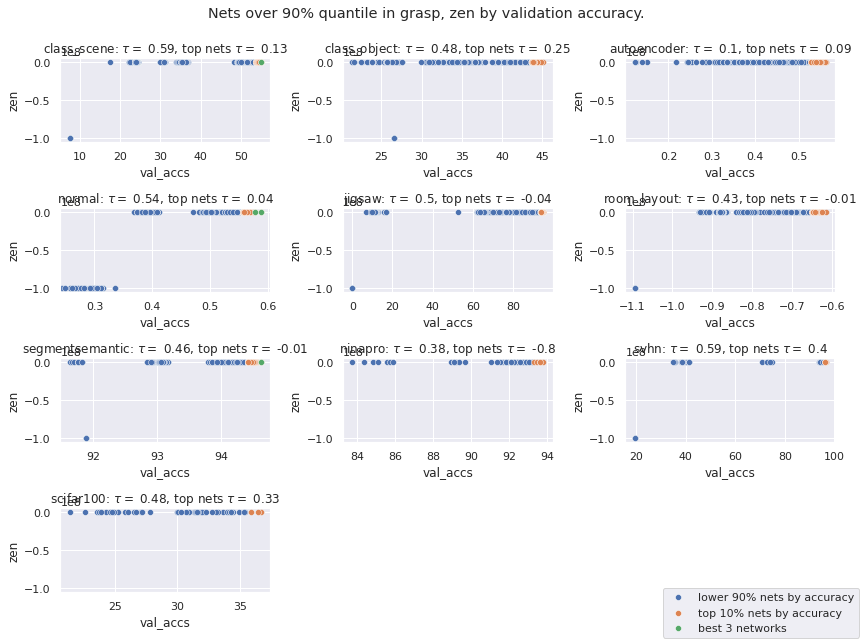

In [30]:
plot_filtered(dfs, 'grasp', 'zen', quantile=0.7)  # TODO do correlation instead of tau